https://www.kaggle.com/code/akankshajadhav24/wholesale-customers-data-using-pca-and-kmeans

In [53]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import DBSCAN
import gower
from sklearn.decomposition import PCA
import optuna
from sklearn.tree import DecisionTreeClassifier

import sys
sys.path.append('../lib')
from visualization_helpers import pareto

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set default font
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/noto_sans_mono/NotoSansMono_SemiCondensed-SemiBold.ttf'
font_prop = fm.FontProperties(fname=font_path)

sns.set(font=font_prop.get_name())
mpl.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.weight"] = 'semibold'

bold = 'extra bold'

In [4]:
random_state = 42

## EDA

In [5]:
# Source: https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set/
original_df = pd.read_csv('data/wholesale-customers-data-set.csv')

In [6]:
df = original_df.copy()

In [7]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [9]:
df.isna().sum().sum()

0

In [10]:
df['Channel'].value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

In [11]:
df['Region'].value_counts()

Region
3    316
1     77
2     47
Name: count, dtype: int64

In [12]:
categorical_columns = ['Channel', 'Region']
numerical_columns = list(set(df.columns) - set(categorical_columns))

# sanity check
if set(numerical_columns + categorical_columns) != set(df.columns):
    raise ValueError("Numerical and categorical columns do not cover all columns")
else:
    print('Numerical columns:   ', len(numerical_columns))
    print('Categorical columns: ', len(categorical_columns))

Numerical columns:    6
Categorical columns:  2


In [13]:
# darkgrid
sns.set_theme(style="darkgrid")

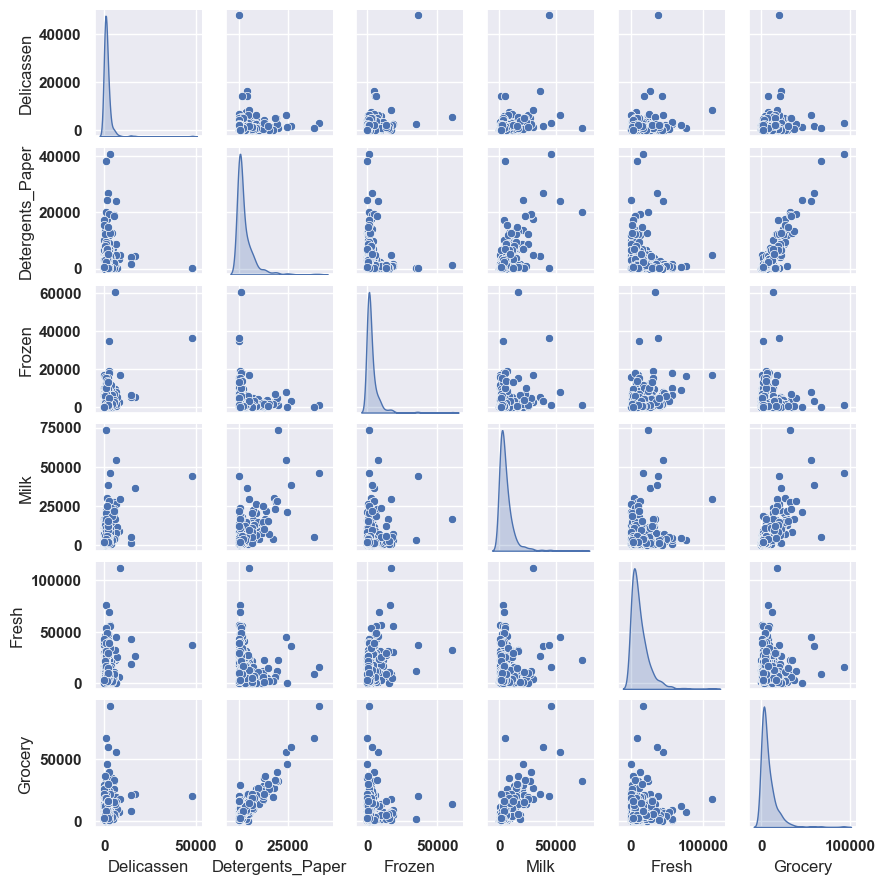

In [14]:
sns.pairplot(df[numerical_columns], diag_kind='kde', height=1.5)

plt.show()

Notice that the distributions are right skewed. We can apply log
transformation to make them more normal.

## Preprocessing

In [15]:
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(df[numerical_columns].values)
X_scaled = np.concatenate([
    X_numerical_scaled,
    df[categorical_columns].values
    ], axis=1)

categorical_idx = [i for i in range(len(X_numerical_scaled[0]),
                                    len(X_scaled[0]))]

In [16]:
# df_log_scaled = df.copy()
# df_log_scaled[numerical_columns] = np.log1p(df_log_scaled[numerical_columns])
# X_numerical_log_scaled = df_log_scaled[numerical_columns].values
# X_log_scaled = np.concatenate([
#     X_numerical_log_scaled,
#     df_log_scaled[categorical_columns].values
#     ], axis=1)

# categorical_idx = [i for i in range(len(X_numerical_log_scaled[0]),
#                                     len(X_log_scaled[0]))]

In [17]:
# sns.pairplot(df_scaled[numerical_columns], diag_kind='kde', height=1.5)
# plt.show()

Check for multicollinearity, I noticed that `Detergents_Paper` and `Grocery` and `Milk` appear correlated.

In [18]:
# plt.figure(figsize=(8, 6))

# corr_matrix = df_log_scaled[numerical_columns].corr()
# sns.heatmap(corr_matrix, annot=True, cmap='Oranges')

# plt.title('Correlation Matrix')

# plt.show()

In [19]:
def run_study(objective, n_trials=50, direction='maximize'):
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Best parameters:", study.best_params)
    print("Best score:", study.best_value)

    return study

def percentage_value_counts(df, feature):
    return (df[feature].value_counts().astype(float) / len(df) * 100).map(lambda x: f"{x:.1f}%")

def mixed_distance(X, labels, categorical_indices):
    """Compute silhouette score for mixed-type data."""
    n_samples = X.shape[0]
    unique_clusters = np.unique(labels)
    silhouette_scores = np.zeros(n_samples)

    for i in range(n_samples):
        current_cluster = labels[i]
        same_cluster = X[labels == current_cluster]
        other_clusters = [X[labels == c] for c in unique_clusters if c != current_cluster]

        # Compute average intra-cluster distance (a(i))
        a_i = np.mean([
            np.linalg.norm(X[i, :].astype(float) - same_cluster[j, :].astype(float))
            for j in range(len(same_cluster)) if j != i
        ]) if len(same_cluster) > 1 else 0

        # Compute average nearest-cluster distance (b(i))
        b_i = np.min([
            np.mean([
                np.linalg.norm(X[i, :].astype(float) - cluster[j, :].astype(float))
                for j in range(len(cluster))
            ]) for cluster in other_clusters
        ]) if other_clusters else 0

        # Compute silhouette score for the point
        silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0

    return np.mean(silhouette_scores)

In [20]:
def objective_kprototypes_silhouette_scaled(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    init = trial.suggest_categorical("init", ["Huang", "Cao"])

    kproto = KPrototypes(
            n_clusters=n_clusters,
            gamma=gamma,
            init=init,
            random_state=random_state
            )

    labels = kproto.fit_predict(
            X_scaled,
            categorical=categorical_idx
            )

    return mixed_distance(X_scaled, labels, categorical_idx)

In [21]:
study = run_study(objective_kprototypes_silhouette_scaled, n_trials=50)
scaled_best_score = study.best_value

[I 2025-02-15 16:56:01,282] A new study created in memory with name: no-name-4712e729-4b91-4d99-94ad-af91bab095e8


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-02-15 16:56:04,167] Trial 0 finished with value: 0.28524190413878425 and parameters: {'n_clusters': 4, 'gamma': 4.6545853951652925, 'init': 'Cao'}. Best is trial 0 with value: 0.28524190413878425.
[I 2025-02-15 16:56:08,908] Trial 1 finished with value: 0.29626400759994703 and parameters: {'n_clusters': 8, 'gamma': 2.951395360965831, 'init': 'Cao'}. Best is trial 1 with value: 0.29626400759994703.
[I 2025-02-15 16:56:12,125] Trial 2 finished with value: 0.29491875168398035 and parameters: {'n_clusters': 5, 'gamma': 4.467988982228193, 'init': 'Huang'}. Best is trial 1 with value: 0.29626400759994703.
[I 2025-02-15 16:56:18,211] Trial 3 finished with value: 0.27566074062225615 and parameters: {'n_clusters': 8, 'gamma': 2.477809604956711, 'init': 'Huang'}. Best is trial 1 with value: 0.29626400759994703.
[I 2025-02-15 16:56:22,881] Trial 4 finished with value: 0.21393702709409543 and parameters: {'n_clusters': 9, 'gamma': 0.1448363751305371, 'init': 'Cao'}. Best is trial 1 with va

[I 2025-02-15 16:58:18,730] Trial 40 finished with value: 0.28517481108277865 and parameters: {'n_clusters': 7, 'gamma': 2.7553087471589217, 'init': 'Huang'}. Best is trial 22 with value: 0.538133326226759.
[I 2025-02-15 16:58:21,600] Trial 41 finished with value: 0.538133326226759 and parameters: {'n_clusters': 2, 'gamma': 0.5886432006109805, 'init': 'Huang'}. Best is trial 22 with value: 0.538133326226759.
[I 2025-02-15 16:58:24,061] Trial 42 finished with value: 0.538133326226759 and parameters: {'n_clusters': 2, 'gamma': 0.5419878221198571, 'init': 'Huang'}. Best is trial 22 with value: 0.538133326226759.
[I 2025-02-15 16:58:26,797] Trial 43 finished with value: 0.29676326507507816 and parameters: {'n_clusters': 3, 'gamma': 0.3612603735013107, 'init': 'Huang'}. Best is trial 22 with value: 0.538133326226759.
[I 2025-02-15 16:58:29,428] Trial 44 finished with value: 0.4215785938451086 and parameters: {'n_clusters': 2, 'gamma': 0.9725383573015545, 'init': 'Huang'}. Best is trial 22 w

<IPython.core.display.Javascript object>

In [22]:
kproto_scaled = KPrototypes(
        n_clusters=study.best_params['n_clusters'],
        gamma=study.best_params['gamma'],
        init=study.best_params['init'],
        random_state=random_state
        )

labels = kproto_scaled.fit_predict(
        X_scaled,
        categorical=categorical_idx
        )

pd.DataFrame(labels).value_counts()

0
1    397
0     43
Name: count, dtype: int64

Let's try without scaling

In [24]:
X = df.values
categorical_idx = [df.columns.get_loc(col) for col in categorical_columns]

In [25]:
def objective_kprototypes_silhouette_not_scaled(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    init = trial.suggest_categorical("init", ["Huang", "Cao"])

    kproto = KPrototypes(
            n_clusters=n_clusters,
            gamma=gamma,
            init=init,
            random_state=random_state
            )

    labels = kproto.fit_predict(
            X,
            categorical=categorical_idx
            )

    return mixed_distance(X, labels, categorical_idx)

In [26]:
study = run_study(objective_kprototypes_silhouette_not_scaled, n_trials=50)
not_scaled_best_score = study.best_value

[I 2025-02-15 16:58:55,123] A new study created in memory with name: no-name-4a4790bf-1379-4284-9d79-79eb7e8eb035


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-02-15 16:58:59,153] Trial 0 finished with value: 0.3770317431052703 and parameters: {'n_clusters': 5, 'gamma': 1.7323018306481128, 'init': 'Cao'}. Best is trial 0 with value: 0.3770317431052703.
[I 2025-02-15 16:59:05,326] Trial 1 finished with value: 0.33344955823922584 and parameters: {'n_clusters': 9, 'gamma': 2.277855365613888, 'init': 'Huang'}. Best is trial 0 with value: 0.3770317431052703.
[I 2025-02-15 16:59:09,855] Trial 2 finished with value: 0.32133807836190575 and parameters: {'n_clusters': 9, 'gamma': 2.44419530795769, 'init': 'Cao'}. Best is trial 0 with value: 0.3770317431052703.
[I 2025-02-15 16:59:14,647] Trial 3 finished with value: 0.3319323289336216 and parameters: {'n_clusters': 8, 'gamma': 2.330398973548831, 'init': 'Cao'}. Best is trial 0 with value: 0.3770317431052703.
[I 2025-02-15 16:59:17,566] Trial 4 finished with value: 0.5143502111105509 and parameters: {'n_clusters': 2, 'gamma': 0.8242502801409528, 'init': 'Huang'}. Best is trial 4 with value: 0.5

[I 2025-02-15 17:01:39,578] Trial 40 finished with value: 0.5143502111105509 and parameters: {'n_clusters': 2, 'gamma': 2.1216356205347493, 'init': 'Huang'}. Best is trial 4 with value: 0.5143502111105509.
[I 2025-02-15 17:01:42,436] Trial 41 finished with value: 0.5143502111105509 and parameters: {'n_clusters': 2, 'gamma': 4.3579469948261735, 'init': 'Huang'}. Best is trial 4 with value: 0.5143502111105509.
[I 2025-02-15 17:01:46,112] Trial 42 finished with value: 0.4809854865263041 and parameters: {'n_clusters': 3, 'gamma': 4.607284617581677, 'init': 'Huang'}. Best is trial 4 with value: 0.5143502111105509.
[I 2025-02-15 17:01:49,081] Trial 43 finished with value: 0.5143502111105509 and parameters: {'n_clusters': 2, 'gamma': 4.386392685895211, 'init': 'Huang'}. Best is trial 4 with value: 0.5143502111105509.
[I 2025-02-15 17:01:53,106] Trial 44 finished with value: 0.4809854865263041 and parameters: {'n_clusters': 3, 'gamma': 3.9088679337205763, 'init': 'Huang'}. Best is trial 4 with

<IPython.core.display.Javascript object>

In [27]:
kproto_not_scaled = KPrototypes(
        n_clusters=study.best_params['n_clusters'],
        gamma=study.best_params['gamma'],
        init=study.best_params['init'],
        random_state=random_state
        )

labels = kproto_not_scaled.fit_predict(
        X,
        categorical=categorical_idx
        )

pd.DataFrame(labels).value_counts()

0
1    375
0     65
Name: count, dtype: int64

## PCA

In [58]:
scaler = StandardScaler()

X_numerical_scaled = scaler.fit_transform(df[numerical_columns].values)
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X_numerical_scaled)
X_pca = np.concatenate([
    X_pca,
    df[categorical_columns].values
    ], axis=1)

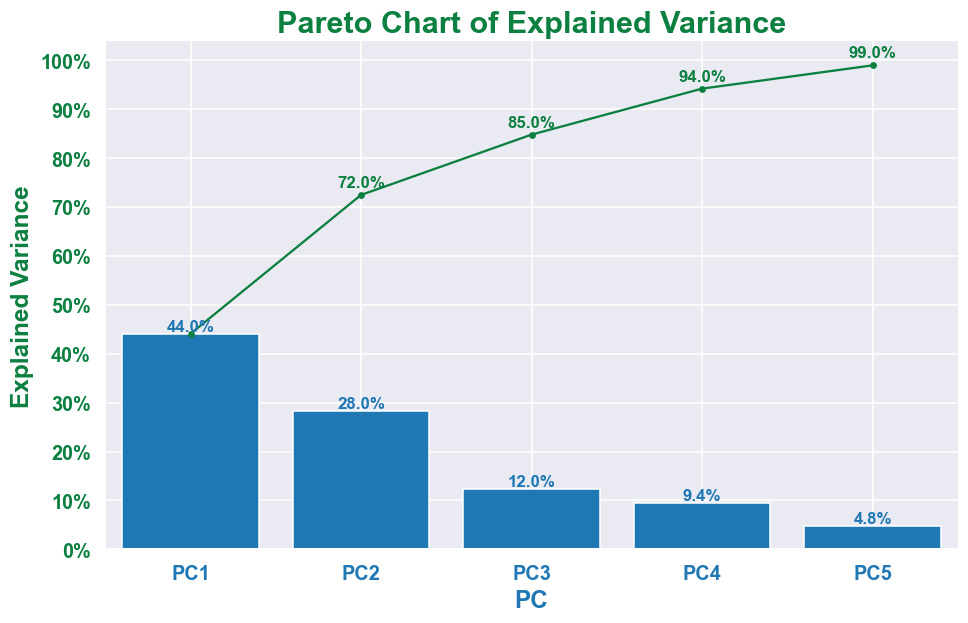

In [59]:
viz_df = pd.DataFrame(
        np.cumsum(pca.explained_variance_ratio_),
        columns=['Explained Variance']
        )

viz_df['PC'] = [f'PC{x}' for x in range(1, len(viz_df) + 1)]
viz_df['Explained Variance'] = (viz_df['Explained Variance'] * 100).round(2)

pareto(
        viz_df=viz_df,
        component_column='PC',
        cumulative_column='Explained Variance',
        bold_key=bold
        )

Select the 4 components that explain > 90% of the variance.

In [60]:
n_components = 4
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_numerical_scaled)
X_pca = np.concatenate([
    X_pca,
    df[categorical_columns].values
    ], axis=1)

In [61]:
def objective_kprototypes_pca(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    init = trial.suggest_categorical("init", ["Huang", "Cao"])

    kproto = KPrototypes(
            n_clusters=n_clusters,
            gamma=gamma,
            init=init,
            random_state=random_state
            )

    labels = kproto.fit_predict(
            X_pca,
            categorical=categorical_idx
            )

    return silhouette_score(X_pca, labels)

In [62]:
study = run_study(objective_kprototypes_pca, n_trials=50, direction='maximize')
pca_best_score = study.best_value

[I 2025-02-15 17:16:14,476] A new study created in memory with name: no-name-d89604ce-7b02-447a-a159-d1df1d531ac9


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-02-15 17:16:17,650] Trial 0 finished with value: 0.2485256045228206 and parameters: {'n_clusters': 6, 'gamma': 1.597038092332782, 'init': 'Huang'}. Best is trial 0 with value: 0.2485256045228206.
[I 2025-02-15 17:16:19,194] Trial 1 finished with value: 0.20379958803063783 and parameters: {'n_clusters': 3, 'gamma': 3.265558158128998, 'init': 'Huang'}. Best is trial 0 with value: 0.2485256045228206.
[I 2025-02-15 17:16:20,474] Trial 2 finished with value: 0.19583737299397636 and parameters: {'n_clusters': 2, 'gamma': 1.076770022388469, 'init': 'Huang'}. Best is trial 0 with value: 0.2485256045228206.
[I 2025-02-15 17:16:23,372] Trial 3 finished with value: 0.19538003764707498 and parameters: {'n_clusters': 8, 'gamma': 2.9863808334684183, 'init': 'Cao'}. Best is trial 0 with value: 0.2485256045228206.
[I 2025-02-15 17:16:26,687] Trial 4 finished with value: 0.17718910367516535 and parameters: {'n_clusters': 10, 'gamma': 2.071626301411436, 'init': 'Huang'}. Best is trial 0 with val

[I 2025-02-15 17:17:58,645] Trial 40 finished with value: 0.2023510225528876 and parameters: {'n_clusters': 4, 'gamma': 3.8570050230416273, 'init': 'Huang'}. Best is trial 10 with value: 0.24963494521909255.
[I 2025-02-15 17:18:01,277] Trial 41 finished with value: 0.1848349065159117 and parameters: {'n_clusters': 7, 'gamma': 4.500051695075794, 'init': 'Cao'}. Best is trial 10 with value: 0.24963494521909255.
[I 2025-02-15 17:18:03,448] Trial 42 finished with value: 0.24963494521909255 and parameters: {'n_clusters': 6, 'gamma': 4.381523318681146, 'init': 'Cao'}. Best is trial 10 with value: 0.24963494521909255.
[I 2025-02-15 17:18:06,308] Trial 43 finished with value: 0.2450434626585838 and parameters: {'n_clusters': 5, 'gamma': 4.764969405550634, 'init': 'Cao'}. Best is trial 10 with value: 0.24963494521909255.
[I 2025-02-15 17:18:09,362] Trial 44 finished with value: 0.2494040469592647 and parameters: {'n_clusters': 6, 'gamma': 2.431162078502137, 'init': 'Cao'}. Best is trial 10 with

<IPython.core.display.Javascript object>

In [63]:
kproto_pca = KPrototypes(
        n_clusters=study.best_params['n_clusters'],
        gamma=study.best_params['gamma'],
        init=study.best_params['init'],
        random_state=random_state
        )

labels = kproto_pca.fit_predict(
        X,
        categorical=categorical_idx
        )

pd.DataFrame(labels).value_counts()

0
4    224
5    104
2     80
0     22
1      7
3      3
Name: count, dtype: int64

In [64]:
print('Scaled:', scaled_best_score)
print('Not scaled:', not_scaled_best_score)
print('PCA:', pca_best_score)

Scaled: 0.538133326226759
Not scaled: 0.5143502111105509
PCA: 0.24963494521909255


In [65]:
# Assume 'X' is your dataset and 'labels' are cluster assignments
clf = DecisionTreeClassifier()
clf.fit(X_scaled, kproto_scaled.predict(
        X_scaled,
        categorical=categorical_idx
        ))

# Feature importance
importances = clf.feature_importances_

In [68]:
series = pd.Series(
        importances,
        index=[*numerical_columns, *categorical_columns]
        ).sort_values(ascending=False)

__df = series.to_frame('Importance').reset_index(names='Feature')
__df

,Feature,Importance
0,Grocery,0.569261
1,Milk,0.192112
2,Region,0.093139
3,Frozen,0.055103
4,Detergents_Paper,0.035593
5,Fresh,0.030040
6,Delicassen,0.024753
7,Channel,0.000000


In [69]:
__df['Importance %'] = (__df['Importance'] * 100).round(2)
__df['Importance Cumulative %'] = np.cumsum(__df['Importance %'])

In [70]:
__df

,Feature,Importance,Importance %,Importance Cumulative %
0,Grocery,0.569261,56.93,56.93
1,Milk,0.192112,19.21,76.14
2,Region,0.093139,9.31,85.45
3,Frozen,0.055103,5.51,90.96
4,Detergents_Paper,0.035593,3.56,94.52
5,Fresh,0.030040,3.00,97.52
6,Delicassen,0.024753,2.48,100.00
7,Channel,0.000000,0.00,100.00


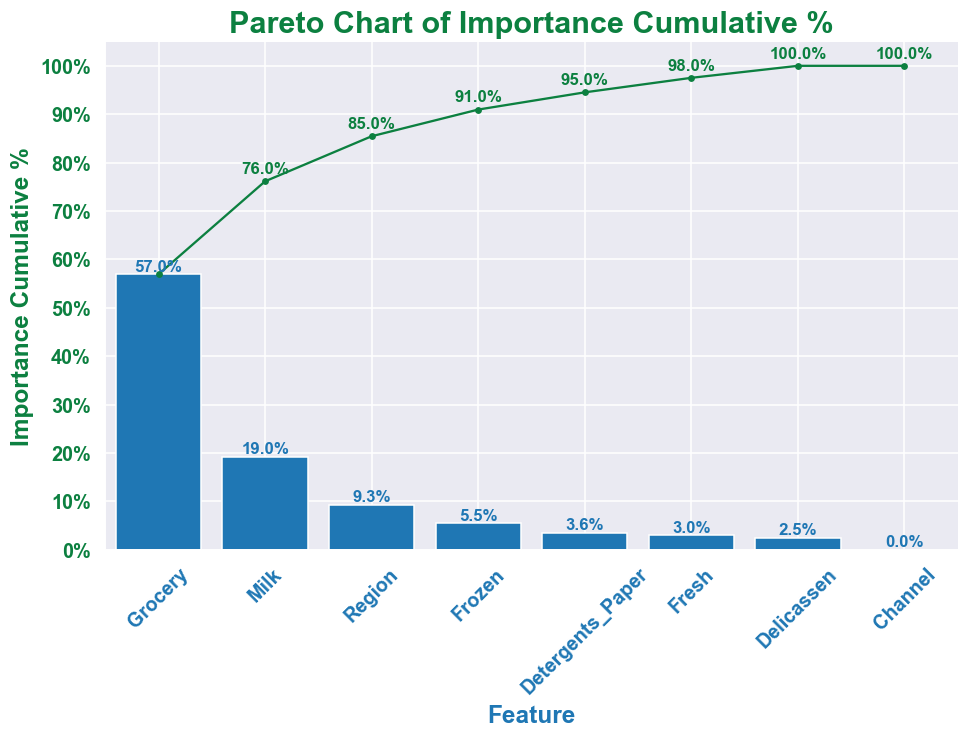

In [71]:
pareto(
        viz_df=__df,
        component_column='Feature',
        cumulative_column='Importance Cumulative %',
        bold_key=bold
        )

In [72]:
# Assume 'X' is your dataset and 'labels' are cluster assignments
clf = DecisionTreeClassifier()
clf.fit(X, kproto_not_scaled.predict(
        X,
        categorical=categorical_idx
        ))

# Feature importance
importances = clf.feature_importances_

In [73]:
series = pd.Series(
        importances,
        index=[*numerical_columns, *categorical_columns]
        ).sort_values(ascending=False)

__df = series.to_frame('Importance').reset_index(names='Feature')
__df

,Feature,Importance
0,Frozen,0.941883
1,Fresh,0.040114
2,Channel,0.018003
3,Delicassen,0.000000
4,Detergents_Paper,0.000000
5,Milk,0.000000
6,Grocery,0.000000
7,Region,0.000000


In [74]:
__df['Importance %'] = (__df['Importance'] * 100).round(2)
__df['Importance Cumulative %'] = np.cumsum(__df['Importance %'])

In [75]:
__df

,Feature,Importance,Importance %,Importance Cumulative %
0,Frozen,0.941883,94.19,94.19
1,Fresh,0.040114,4.01,98.20
2,Channel,0.018003,1.80,100.00
3,Delicassen,0.000000,0.00,100.00
4,Detergents_Paper,0.000000,0.00,100.00
5,Milk,0.000000,0.00,100.00
6,Grocery,0.000000,0.00,100.00
7,Region,0.000000,0.00,100.00


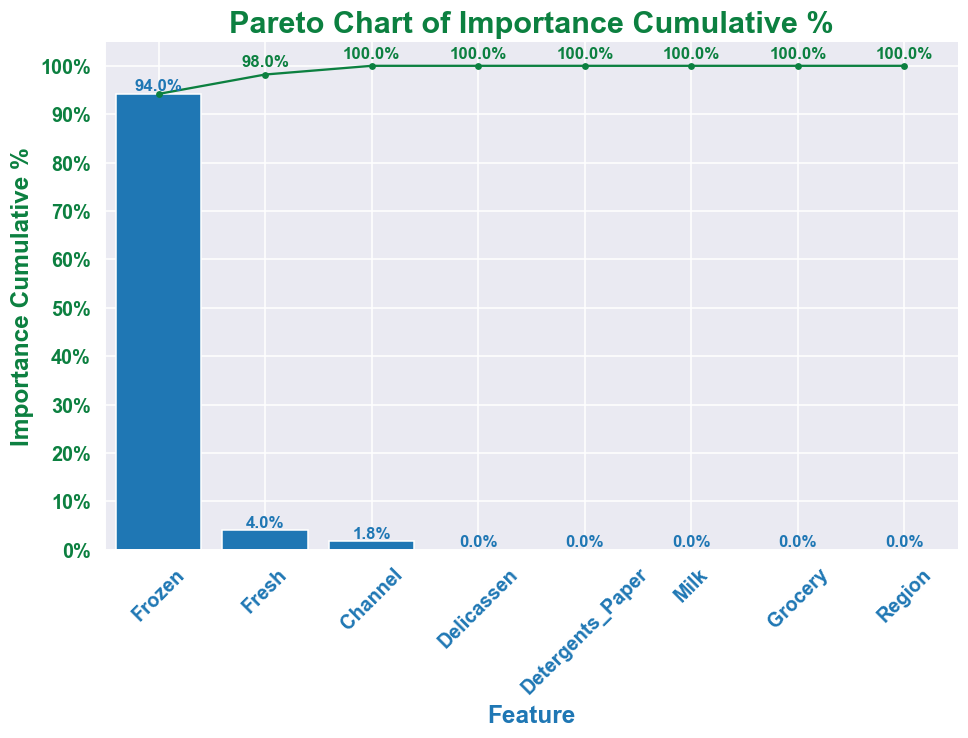

In [76]:
pareto(
        viz_df=__df,
        component_column='Feature',
        cumulative_column='Importance Cumulative %',
        bold_key=bold
        )